In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import re
import nltk
import sklearn
%matplotlib inline

In [2]:
clean_data = pd.read_excel('clean.xlsx')

In [3]:
clean_data = clean_data.iloc[np.random.permutation(len(clean_data))]

In [4]:
clean_data = clean_data.reset_index(drop=True)

# Making bag of words model

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

allthetext = []
for i in xrange(len(clean_data)):
    allthetext.append(clean_data['Text'][i])

In [11]:
len(allthetext)

21768

In [12]:
allthewords = {}

for text in allthetext:
    for word in text.split():
        if word in allthewords:
            allthewords[word] = allthewords[word] + 1
        else:
            allthewords[word] = 1
    


In [13]:
import operator
sorted_all = sorted(allthewords.items(), key=operator.itemgetter(1))

In [14]:
sorted_all.reverse()

In [15]:
len(allthewords)

58682

# There are 58683 unique words, and I have to select which are the most important ones(by frequency) for feature

In [16]:
np.unique(clean_data['Category'])

array([u'Canola', u'Corn', u'Hay & Forage', u'Pulse', u'Soybeans', u'Wheat'], dtype=object)

In [17]:
subset_sorted = [(a,b) for (a,b) in sorted_all if b>1000]

In [18]:
len(subset_sorted)

1065

# Seems like 1000 frequency threshold gives 1066 unique words, lets keep that for now

In [19]:
feature_words = [a for (a,b) in subset_sorted]

In [21]:
vectorizer = CountVectorizer(analyzer='word', tokenizer=None, preprocessor=None, stop_words=None, max_features=50000)

In [22]:
clean_text_list = []
for i in xrange(len(clean_data)):
    clean_text_list.append(clean_data['Text'][i])

In [23]:
train_features = vectorizer.fit_transform(clean_text_list)

In [24]:
vocab = vectorizer.get_feature_names()
#print(vocab)

In [25]:
train_features = train_features.toarray()

In [26]:
train_features.shape

(21768, 50000)

# Creating a training, validation and test split

In [21]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_features, clean_data['Category'], test_size = 0.10, random_state = 0)

In [22]:
data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

In [23]:
print(len(data_train))
print(len(data_validation))
print(len(data_test))

15672
3919
2177


In [24]:
print(len(labels_train))
print(len(labels_validation))
print(len(labels_test))

15672
3919
2177


# Trying out out of the box Random Forest model

In [25]:
from sklearn.ensemble import RandomForestClassifier


In [33]:
scores_validation = []
scores_train = []
for i in xrange(300,1000,100):
    print(i)
    forest = RandomForestClassifier(n_estimators = i)
    forest = forest.fit(data_train, labels_train)
    
    results_validation = forest.predict(data_validation)
    curr_score_valid = sklearn.metrics.accuracy_score(labels_validation, results_validation, normalize = True)
    
    results_train = forest.predict(data_train)
    curr_score_train = sklearn.metrics.accuracy_score(labels_train, results_train, normalize=True)
    
    scores_validation.append((i,curr_score_valid))
    scores_train.append((i,curr_score_train))

300
400
500
600
700
800
900


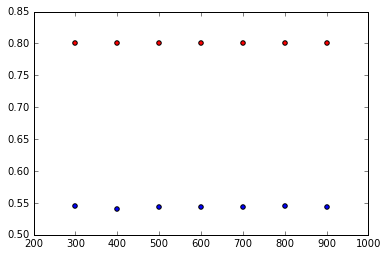

In [34]:
plt.scatter(*zip(*scores_train),c='r')
plt.scatter(*zip(*scores_validation),c='b')

In [35]:
forest = RandomForestClassifier(n_estimators = 500)
forest = forest.fit(data_train, labels_train)
    
results_validation = forest.predict(data_validation)
curr_score_valid = sklearn.metrics.accuracy_score(labels_validation, results_validation, normalize = True)
curr_score_valid    

0.54095432508292929

In [38]:
5904/float(len(clean_data))

0.27122381477398017

# Try logistic regression model  -- l1 penalty = 0.023299518105153717 , tol = 0.012742749857031334 , best accuracy 66%

In [50]:
np.logspace(-10,10,20)

array([  1.00000000e-10,   1.12883789e-09,   1.27427499e-08,
         1.43844989e-07,   1.62377674e-06,   1.83298071e-05,
         2.06913808e-04,   2.33572147e-03,   2.63665090e-02,
         2.97635144e-01,   3.35981829e+00,   3.79269019e+01,
         4.28133240e+02,   4.83293024e+03,   5.45559478e+04,
         6.15848211e+05,   6.95192796e+06,   7.84759970e+07,
         8.85866790e+08,   1.00000000e+10])

In [61]:
from sklearn.linear_model import LogisticRegression

l1error=[]
l2error=[]
i=0
for c in np.logspace(-10,0,50):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    regressionl1 = LogisticRegression(penalty='l1', C=c, tol=0.1)
    regressionl2 = LogisticRegression(penalty='l2', C=c, tol=0.1)
    
    regressionl1.fit(data_train, labels_train)
    regressionl2.fit(data_train, labels_train)
    
    l1error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl1.predict(data_validation), normalize=True)))
    
    l2error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl2.predict(data_validation), normalize=True)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


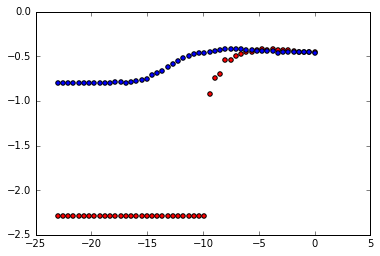

In [62]:
plt.scatter(*zip(*np.log(l1error)),c='r')
plt.scatter(*zip(*np.log(l2error)),c='b')

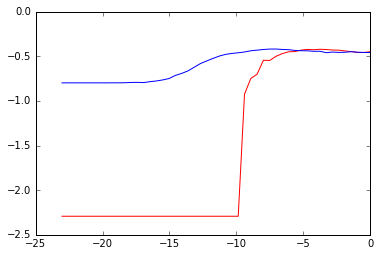

In [63]:
plt.plot(*zip(*np.log(l1error)),c='r')
plt.plot(*zip(*np.log(l2error)),c='b')

In [72]:
regressionl1 = LogisticRegression(penalty='l1', C=0.023299518105153717, tol=0.1)

In [73]:
regressionl1.fit(data_train,  labels_train)
sklearn.metrics.accuracy_score(labels_validation, regressionl1.predict(data_validation))

0.65220719571319219

In [70]:
l1error.sort(key=lambda tup: tup[1])
l1error[-1]

(0.023299518105153717, 0.65577953559581526)

In [71]:
l2error.sort(key=lambda tup: tup[1])
l2error[-1]

(0.000868511373751352, 0.65756570553712679)

array([[ 0.        ,  0.        , -0.00603442, ..., -0.05067279,
         0.        ,  0.        ],
       [ 0.06977585,  0.05154468,  0.02358636, ...,  0.        ,
         0.00314876, -0.02112861],
       [ 0.        ,  0.        ,  0.00837067, ...,  0.        ,
        -0.04483906, -0.04690264],
       [ 0.        ,  0.        , -0.00291551, ..., -0.00655638,
        -0.03463418,  0.        ],
       [ 0.        , -0.00731044,  0.        , ...,  0.        ,
         0.        ,  0.00645485],
       [-0.02208363,  0.        ,  0.003616  , ...,  0.        ,
        -0.02424734,  0.        ]])

In [77]:
from sklearn.linear_model import LogisticRegression

tolerror=[]
traerror=[]
i=0
for c in np.logspace(-4,0,20):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    regressionl1 = LogisticRegression(penalty='l1', C=0.023299518105153717, tol=c)
    #regressionl2 = LogisticRegression(penalty='l2', C=c, tol=0.1)
    
    regressionl1.fit(data_train, labels_train)
    #regressionl2.fit(data_train, labels_train)
    
    tolerror.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl1.predict(data_validation), normalize=True)))
    traerror.append((c,sklearn.metrics.accuracy_score(labels_train,regressionl1.predict(data_train), normalize=True)))
    
    #l2error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl2.predict(data_validation), normalize=True)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


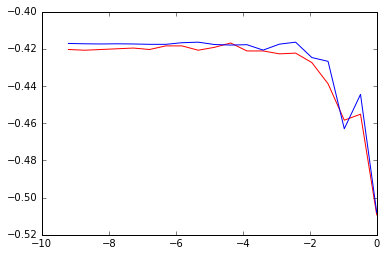

In [78]:
plt.plot(*zip(*np.log(tolerror)),c='r')
plt.plot(*zip(*np.log(traerror)),c='b')

In [79]:
tolerror.sort(key=lambda tup: tup[1])
tolerror[-1]

(0.012742749857031334, 0.65909670834396528)

In [80]:
bestlogistic = LogisticRegression(penalty = 'l1', C = 0.023299518105153717, tol = 0.012742749857031334)

bestlogistic.fit(data_train_and_validation, labels_train_and_validation)

sklearn.metrics.accuracy_score(labels_test, bestlogistic.predict(data_test))

0.65870463941203494